**Note**. Save this Colab notebook to your Drive via File > Save a copy in Drive to be able to edit it.

# 1. Upload data files

Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder.

You can upload the files via `files.upload()` code cell below OR use the upload function in the window to the left (lcik on folder icon and then click on upload icon).

In [ ]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving Assignment3-Shuhan Wang.csv to Assignment3-Shuhan Wang.csv
Saving stock_des.csv to stock_des.csv
Saving tickers.txt to tickers.txt


# 2. Install, load the libraries

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Device:', torch.device('cuda:0'))

Device: cuda:0


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

# 2. Load, merge, clean the data

The three finacial ratios we chose are 'Current Ratio', 'Total Debt/Equity' and 'Cash Flow/Total Debt'. The calculation of them are as follows:


**1.   Current Ratio = Current Assets/Current Liabilities**

  (In dataframe: 'Current Assets' is 'act' and 'Current Liabilities' is 'lct')

  The current ratio is a measure of a company's ability to pay its short-term debts. This ratio directly reflects whether a company has enough current assets to cover its current liabilities.

  The textual business description often includes details about a company's operating cycle, liquidity management, and working capital usage. For example, a company that mentions a significant amount of inventory in its business model might have a different current ratio compared to a service-oriented company with minimal inventory. Thus, the nature of operations as described in the text can provide context for the current ratio observed.

**2.   Total Debt/Equity = Total Liabilities/Shareholders' Equity**

  (In dataframe: 'Total Liabilities' is 'lt' and 'Shareholders' Equity' is 'teq')

  This ratio measures the degree of a company's financial leverage, that is, the proportion of debt used by the company relative to shareholder equity. A higher ratio may indicate a greater dependence of the company on debt.

  The business description may detail the company’s growth strategy, including whether it is aggressively pursuing expansions through borrowing or taking a more conservative approach. Companies in capital-intensive industries, such as utilities or manufacturing, may typically have higher debt levels, as reflected in their business models and described in their textual descriptions. In contrast, tech companies might rely more on equity financing for their operations and growth.

**3.   Cash Flow = Operation Cash Flow/Total Debt**

  (In dataframe: 'Operation Cash Flow' is 'oancf' and 'Total Debt' is 'dt')

  This ratio shows the company's ability to pay off its total debt with the cash flow generated from its operating activities. It is an important measure of a company's debt repayment capability.

  A company’s business description detailing consistent revenue streams, efficient cash cycle, and profitability would suggest a stronger capability to service debt, potentially resulting in a higher cash flow to total debt ratio. Conversely, companies in industries with volatile earnings or heavy investment phases might have lower values for this ratio, which could be inferred from their business descriptions.




In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
df = pd.read_csv('Assignment3-Shuhan Wang.csv')

In [ ]:
# clean up the column names
df.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)
stock_des.rename(columns={'Unnamed: 0': 'ticker'}, inplace=True)

In [ ]:
# merge the dataframes into one
df = pd.merge(df, stock_des, on='ticker')

In [ ]:
df

,ticker,act,dt,lct,lt,oancf,teq,description
0,AIR,1097.900,330.200,351.500,734.000,23.300,1099.100,AAR Corp. provides products and services to co...
1,AAL,13572.000,40663.000,22062.000,68260.000,3803.000,-5202.000,"American Airlines Group Inc., through its subs..."
2,PNW,1926.967,NaN,2889.347,18376.291,1207.697,6284.862,"Pinnacle West Capital Corporation, through its..."
3,PRG,NaN,608.114,NaN,899.924,204.236,591.331,"PROG Holdings, Inc. operates as an omnichannel..."
4,ABT,22670.000,15873.000,13841.000,34387.000,7261.000,38827.000,"Abbott Laboratories discovers, develops, manuf..."
...,...,...,...,...,...,...,...,...
2907,APG,2582.000,2574.000,1807.000,4722.000,514.000,2868.000,"APi Group Corporation provides safety, special..."
2908,NVT,1336.100,1904.700,733.600,3019.600,528.100,3142.100,"nVent Electric plc designs, manufactures, mark..."
2909,ACA,912.000,606.800,431.200,1245.900,261.000,2332.000,"Arcosa, Inc., together with its subsidiaries, ..."
2910,HYFM,128.066,183.931,37.652,217.033,7.044,290.610,"Hydrofarm Holdings Group, Inc., together with ..."


In [ ]:
# remove the observations with ta and rev less than 10000
print(df.shape)
#df = df[(df['Total Assets'] >= 10000) & (df['Total Revenue'] >= 10000)]
#print(df.shape)

(2912, 8)


In [ ]:
# create the assets to revenue ratio
df['Current Ratio'] = df['act']/df['lct']
df['Total Debt/Equity'] = df['lt']/df['teq']
df['Cash Flow/Total Debt'] = df['oancf']/df['dt']

After creating these three ratios with my raw data, I decide to do the next steps in three different data frame for these three ratios to use the datas better.
(If we use the same dataframe for these 3 ratios, when doing data preprocessing we may delete to many data. Because companies have different loss or mistakes with different kind of data. Seperating them will increase the efficiency)

df_1 is for Current Ratio.

df_2 is for Total Debt/Equity.

df_3 is for Cash Flow/Total Debt.

count    1854.000000
mean        2.822206
std         3.398876
min         0.000000
25%         1.183241
50%         1.781978
75%         3.117880
max        42.927432
Name: Current Ratio, dtype: float64


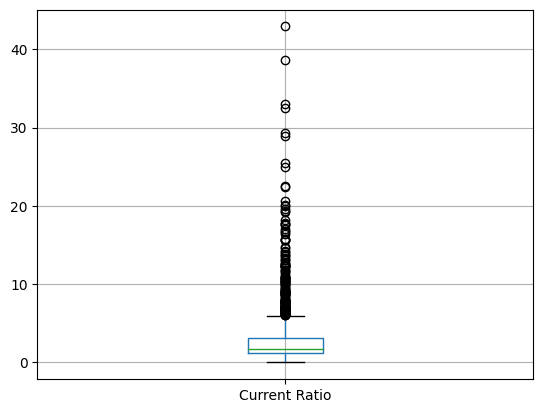

In [ ]:
print(df['Current Ratio'].describe())
df.boxplot(column='Current Ratio');

*We* have about 10 outliers with the ratio of 20+. Let's remove them.

In [ ]:
df_1 = df[df['Current Ratio']<22]
print(df_1.shape)

(1844, 11)


count    2902.000000
mean        3.485730
std        10.645759
min      -237.349080
25%         0.726765
50%         1.622584
75%         5.681347
max       171.678645
Name: Total Debt/Equity, dtype: float64


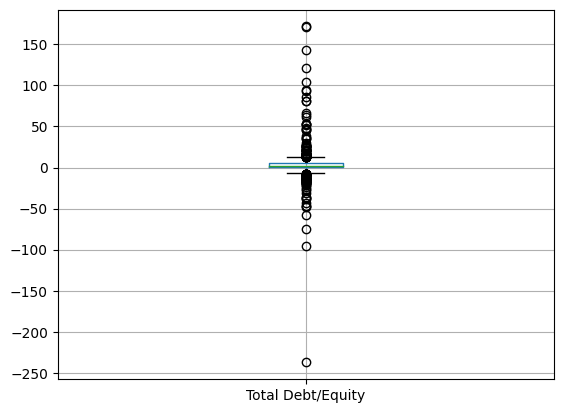

In [ ]:
print(df['Total Debt/Equity'].describe())
df.boxplot(column='Total Debt/Equity');

We have about 15 outliers with the ratio of 70+ or -50-. Let's remove them.

In [ ]:
df_2 = df[df['Total Debt/Equity']<75]
df_2 = df[df['Total Debt/Equity']>-50]
print(df_2.shape)

(2898, 11)


count    2063.000000
mean             NaN
std              NaN
min             -inf
25%         0.060054
50%         0.213008
75%         0.495368
max              inf
Name: Cash Flow/Total Debt, dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


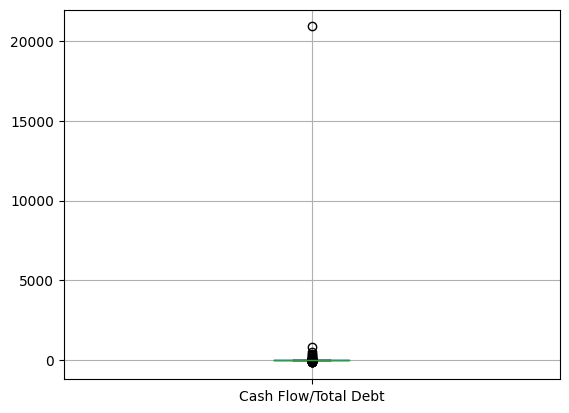

In [ ]:
print(df['Cash Flow/Total Debt'].describe())
df.boxplot(column='Cash Flow/Total Debt');

*We* have 1 outliers with the ratio of 20000+. Let's remove them.

In [ ]:
df_3 = df[df['Cash Flow/Total Debt']<5000]
print(df_3.shape)

(2052, 11)


Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise.

This is the **dependent variable** (label) that we'll try to predict.

First, we use df_1 to do the next work with Current Ratio.

In [ ]:
columns_drop_1 = ['Total Debt/Equity','Cash Flow/Total Debt','dt','teq','oancf','lt']
df_1 = df.drop(columns_drop_1, axis=1)

In [ ]:
df_1 = df_1.dropna()
df_1

,ticker,act,lct,description,Current Ratio
0,AIR,1097.900,351.500,AAR Corp. provides products and services to co...,3.123471
1,AAL,13572.000,22062.000,"American Airlines Group Inc., through its subs...",0.615175
2,PNW,1926.967,2889.347,"Pinnacle West Capital Corporation, through its...",0.666921
4,ABT,22670.000,13841.000,"Abbott Laboratories discovers, develops, manuf...",1.637887
5,AMD,16768.000,6689.000,"Advanced Micro Devices, Inc. operates as a sem...",2.506802
...,...,...,...,...,...
2907,APG,2582.000,1807.000,"APi Group Corporation provides safety, special...",1.428888
2908,NVT,1336.100,733.600,"nVent Electric plc designs, manufactures, mark...",1.821292
2909,ACA,912.000,431.200,"Arcosa, Inc., together with its subsidiaries, ...",2.115028
2910,HYFM,128.066,37.652,"Hydrofarm Holdings Group, Inc., together with ...",3.401307


In [ ]:
df_1['HIGH_ARR'] = (df_1['Current Ratio'].gt(df_1['Current Ratio'].median())).astype(int)

In [ ]:
df_1=df_1.sample(1500, random_state=6887)
df_1=df_1.reset_index(drop=True)

Due to Colab's RAM limitations, limit the description size. We'll only keep 1st sentence of each description. In case if you have Pro subscription you can increase the number of sentences/try random sentences from descriptions/use full descriptions. (Observed improvement is marginal.)

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
df_1['token_count'] = df_1['description'].apply(lambda x: len(word_tokenize(x)))
print(df_1.shape)
df_1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1500, 7)


,ticker,act,lct,description,Current Ratio,HIGH_ARR,token_count
0,BIIB,6859.300,3434.300,"Biogen Inc. discovers, develops, manufactures,...",1.997292,1,336
1,SWN,1415.000,1729.000,"Southwestern Energy Company, an independent en...",0.818392,0,177
2,NBR,1645.678,1213.981,Nabors Industries Ltd. provides drilling and d...,1.355604,0,248
3,VLGEA,246.687,178.973,"Village Super Market, Inc. operates a chain of...",1.378348,0,99
4,AEO,1100.241,768.948,"American Eagle Outfitters, Inc. operates as a ...",1.430839,0,183
...,...,...,...,...,...,...,...
1495,SEB,3363.000,1335.000,Seaboard Corporation operates as an agribusine...,2.519101,1,296
1496,MCO,4341.000,2500.000,Moody's Corporation operates as an integrated ...,1.736400,0,306
1497,HRB,1187.486,938.782,"H&amp;R Block, Inc., through its subsidiaries,...",1.264922,0,270
1498,RLMD,97.509,12.195,"Relmada Therapeutics, Inc., a clinical-stage b...",7.995818,1,132


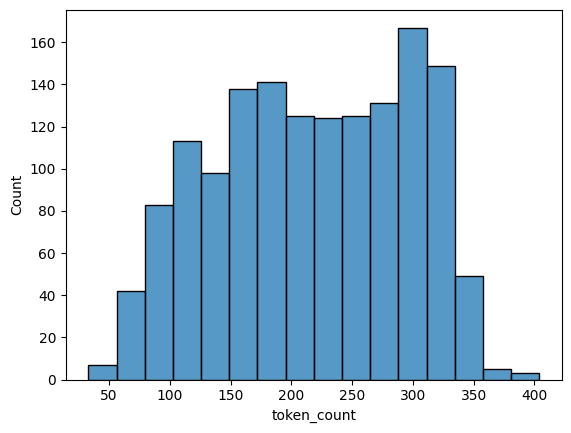

In [ ]:
import seaborn as sns
sns.histplot(data=df_1, x="token_count");

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
df_1['text'] = df_1['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df_1['token_count'].quantile(0.00)
upper_threshold = df_1['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df_1 = df_1[(df_1['token_count'] >= lower_threshold) & (df_1['token_count'] <= upper_threshold)]

trimmed_df_1

,ticker,act,lct,description,Current Ratio,HIGH_ARR,token_count,text
0,BIIB,6859.300,3434.300,"Biogen Inc. discovers, develops, manufactures,...",1.997292,1,336,"Biogen Inc. discovers, develops, manufactures,..."
1,SWN,1415.000,1729.000,"Southwestern Energy Company, an independent en...",0.818392,0,177,"Southwestern Energy Company, an independent en..."
2,NBR,1645.678,1213.981,Nabors Industries Ltd. provides drilling and d...,1.355604,0,248,Nabors Industries Ltd. provides drilling and d...
3,VLGEA,246.687,178.973,"Village Super Market, Inc. operates a chain of...",1.378348,0,99,"Village Super Market, Inc. operates a chain of..."
4,AEO,1100.241,768.948,"American Eagle Outfitters, Inc. operates as a ...",1.430839,0,183,"American Eagle Outfitters, Inc. operates as a ..."
...,...,...,...,...,...,...,...,...
1495,SEB,3363.000,1335.000,Seaboard Corporation operates as an agribusine...,2.519101,1,296,Seaboard Corporation operates as an agribusine...
1496,MCO,4341.000,2500.000,Moody's Corporation operates as an integrated ...,1.736400,0,306,Moodys Corporation operates as an integrated r...
1497,HRB,1187.486,938.782,"H&amp;R Block, Inc., through its subsidiaries,...",1.264922,0,270,"HampR Block, Inc., through its subsidiaries, p..."
1498,RLMD,97.509,12.195,"Relmada Therapeutics, Inc., a clinical-stage b...",7.995818,1,132,"Relmada Therapeutics, Inc., a clinicalstage bi..."


In [ ]:
trimmed_df_1=trimmed_df_1[trimmed_df_1["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df_1=trimmed_df_1[trimmed_df_1["ticker"]!="BIIB"]
trimmed_df_1=trimmed_df_1.reset_index(drop=True)

In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df_1['text'] = trimmed_df_1['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df_1.head(3)

,ticker,act,lct,description,Current Ratio,HIGH_ARR,token_count,text
0,SWN,1415.000,1729.000,"Southwestern Energy Company, an independent en...",0.818392,0,177,"Southwestern Energy Company, an independent en..."
1,NBR,1645.678,1213.981,Nabors Industries Ltd. provides drilling and d...,1.355604,0,248,Nabors Industries Ltd. provides drilling and d...
2,VLGEA,246.687,178.973,"Village Super Market, Inc. operates a chain of...",1.378348,0,99,"Village Super Market, Inc. operates a chain of..."


Then, we use df_2 to do the next work with Total Debt/Equity.

In [ ]:
columns_drop_2 = ['Cash Flow/Total Debt','Current Ratio','act','lct','oancf','dt']
df_2 = df.drop(columns_drop_2, axis=1)
df_2 = df_2.dropna()

In [ ]:
df_2['HIGH_ARR'] = (df_2['Total Debt/Equity'].gt(df_2['Total Debt/Equity'].median())).astype(int)

In [ ]:
df_2=df_2.sample(2000, random_state=6887)
df_2=df_2.reset_index(drop=True)

Due to Colab's RAM limitations, limit the description size. We'll only keep 1st sentence of each description. In case if you have Pro subscription you can increase the number of sentences/try random sentences from descriptions/use full descriptions. (Observed improvement is marginal.)

In [ ]:
# Count the number of tokens in the 'text' column
df_2['token_count'] = df_2['description'].apply(lambda x: len(word_tokenize(x)))
print(df_2.shape)
df_2

(2000, 7)


,ticker,lt,teq,description,Total Debt/Equity,HIGH_ARR,token_count
0,CMTL,445.727,550.510,"Comtech Telecommunications Corp. designs, deve...",0.809662,0,290
1,MLI,400.585,2358.716,"Mueller Industries, Inc. manufactures and sell...",0.169832,0,325
2,JBGS,2825.929,2251.849,"JBG SMITH is an S&amp;P 400 company that owns,...",1.254937,0,116
3,XRAY,4076.000,3294.000,"DENTSPLY SIRONA Inc. designs, develops, manufa...",1.237401,0,304
4,BLK,81971.000,39500.000,"BlackRock, Inc. is a publicly owned investment...",2.075215,1,419
...,...,...,...,...,...,...,...
1995,ASC,116.507,574.444,Ardmore Shipping Corporation engages in the se...,0.202817,0,70
1996,ALGT,3540.850,1328.560,"Allegiant Travel Company, a leisure travel com...",2.665179,1,184
1997,EVH,1434.180,1246.128,"Evolent Health, Inc., through its subsidiary, ...",1.150909,0,183
1998,MCS,593.931,471.172,"The Marcus Corporation, together with its subs...",1.260540,0,151


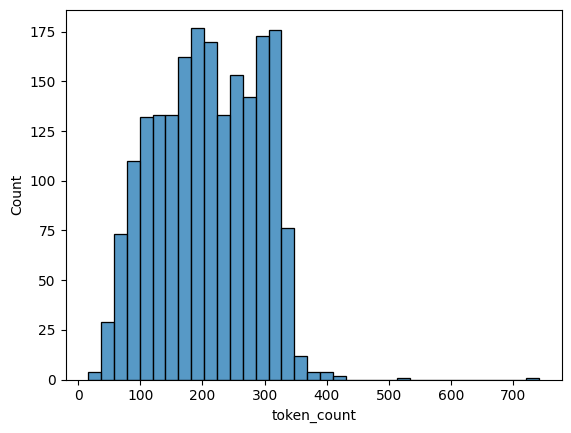

In [ ]:
sns.histplot(data=df_2, x="token_count");

In [ ]:
# Apply the function to the 'text' column
df_2['text'] = df_2['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df_2['token_count'].quantile(0.00)
upper_threshold = df_2['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df_2 = df_2[(df_2['token_count'] >= lower_threshold) & (df_2['token_count'] <= upper_threshold)]

trimmed_df_2

,ticker,lt,teq,description,Total Debt/Equity,HIGH_ARR,token_count,text
0,CMTL,445.727,550.510,"Comtech Telecommunications Corp. designs, deve...",0.809662,0,290,"Comtech Telecommunications Corp. designs, deve..."
1,MLI,400.585,2358.716,"Mueller Industries, Inc. manufactures and sell...",0.169832,0,325,"Mueller Industries, Inc. manufactures and sell..."
2,JBGS,2825.929,2251.849,"JBG SMITH is an S&amp;P 400 company that owns,...",1.254937,0,116,"JBG SMITH is an SampP 400 company that owns, o..."
3,XRAY,4076.000,3294.000,"DENTSPLY SIRONA Inc. designs, develops, manufa...",1.237401,0,304,"DENTSPLY SIRONA Inc. designs, develops, manufa..."
5,JBL,16557.000,2867.000,Jabil Inc. provides manufacturing services and...,5.775026,1,307,Jabil Inc. provides manufacturing services and...
...,...,...,...,...,...,...,...,...
1995,ASC,116.507,574.444,Ardmore Shipping Corporation engages in the se...,0.202817,0,70,Ardmore Shipping Corporation engages in the se...
1996,ALGT,3540.850,1328.560,"Allegiant Travel Company, a leisure travel com...",2.665179,1,184,"Allegiant Travel Company, a leisure travel com..."
1997,EVH,1434.180,1246.128,"Evolent Health, Inc., through its subsidiary, ...",1.150909,0,183,"Evolent Health, Inc., through its subsidiary, ..."
1998,MCS,593.931,471.172,"The Marcus Corporation, together with its subs...",1.260540,0,151,"The Marcus Corporation, together with its subs..."


In [ ]:
trimmed_df_2=trimmed_df_2[trimmed_df_2["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df_2=trimmed_df_2[trimmed_df_2["ticker"]!="BIIB"]
trimmed_df_2=trimmed_df_2.reset_index(drop=True)

In [ ]:
# Apply the function to the 'text' column
trimmed_df_2['text'] = trimmed_df_2['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df_2.head(3)

,ticker,lt,teq,description,Total Debt/Equity,HIGH_ARR,token_count,text
0,CMTL,445.727,550.510,"Comtech Telecommunications Corp. designs, deve...",0.809662,0,290,"Comtech Telecommunications Corp. designs, deve..."
1,MLI,400.585,2358.716,"Mueller Industries, Inc. manufactures and sell...",0.169832,0,325,"Mueller Industries, Inc. manufactures and sell..."
2,JBGS,2825.929,2251.849,"JBG SMITH is an S&amp;P 400 company that owns,...",1.254937,0,116,"JBG SMITH is an SampP 400 company that owns, o..."


Finally, we use df_3 to do the next work with Cash Flow/Total Debt.

In [ ]:
columns_drop_3 = ['Total Debt/Equity','Current Ratio','act','lct','lt','teq']
df_3 = df.drop(columns_drop_3, axis=1)
df_3 = df_3.dropna()

In [ ]:
df_3['HIGH_ARR'] = (df_3['Cash Flow/Total Debt'].gt(df_3['Cash Flow/Total Debt'].median())).astype(int)

In [ ]:
df_3=df_3.sample(2000, random_state=6887)
df_3=df_3.reset_index(drop=True)

Due to Colab's RAM limitations, limit the description size. We'll only keep 1st sentence of each description. In case if you have Pro subscription you can increase the number of sentences/try random sentences from descriptions/use full descriptions. (Observed improvement is marginal.)

In [ ]:
# Count the number of tokens in the 'text' column
df_3['token_count'] = df_3['description'].apply(lambda x: len(word_tokenize(x)))
print(df_3.shape)
df_3

(2000, 7)


,ticker,dt,oancf,description,Cash Flow/Total Debt,HIGH_ARR,token_count
0,BTU,399.200,1035.500,Peabody Energy Corporation engages in coal min...,2.593938,1,217
1,ST,3439.959,456.675,"Sensata Technologies Holding plc, through its ...",0.132756,0,317
2,MMI,87.743,-72.430,"Marcus &amp; Millichap, Inc., an investment br...",-0.825479,0,194
3,TTGT,431.164,72.489,"TechTarget, Inc., together with its subsidiari...",0.168124,0,192
4,AMBC,3497.000,200.000,"Ambac Financial Group, Inc., a financial servi...",0.057192,0,68
...,...,...,...,...,...,...,...
1995,DVA,11116.421,2059.031,DaVita Inc. provides kidney dialysis services ...,0.185224,0,213
1996,VSH,947.503,365.703,"Vishay Intertechnology, Inc. manufactures and ...",0.385965,1,276
1997,LBRT,405.309,1014.583,Liberty Oilfield Services Inc. provides hydrau...,2.503233,1,125
1998,OI,5068.000,818.000,"O-I Glass, Inc., through its subsidiaries, man...",0.161405,0,127


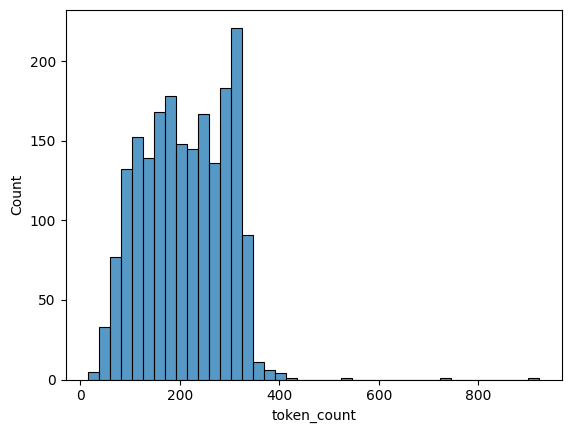

In [ ]:
import seaborn as sns
sns.histplot(data=df_3, x="token_count");

In [ ]:
# Apply the function to the 'text' column
df_3['text'] = df_3['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df_3['token_count'].quantile(0.00)
upper_threshold = df_3['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df_3 = df_3[(df_3['token_count'] >= lower_threshold) & (df_3['token_count'] <= upper_threshold)]

trimmed_df_3

,ticker,dt,oancf,description,Cash Flow/Total Debt,HIGH_ARR,token_count,text
0,BTU,399.200,1035.500,Peabody Energy Corporation engages in coal min...,2.593938,1,217,Peabody Energy Corporation engages in coal min...
1,ST,3439.959,456.675,"Sensata Technologies Holding plc, through its ...",0.132756,0,317,"Sensata Technologies Holding plc, through its ..."
2,MMI,87.743,-72.430,"Marcus &amp; Millichap, Inc., an investment br...",-0.825479,0,194,"Marcus amp Millichap, Inc., an investment brok..."
3,TTGT,431.164,72.489,"TechTarget, Inc., together with its subsidiari...",0.168124,0,192,"TechTarget, Inc., together with its subsidiari..."
4,AMBC,3497.000,200.000,"Ambac Financial Group, Inc., a financial servi...",0.057192,0,68,"Ambac Financial Group, Inc., a financial servi..."
...,...,...,...,...,...,...,...,...
1995,DVA,11116.421,2059.031,DaVita Inc. provides kidney dialysis services ...,0.185224,0,213,DaVita Inc. provides kidney dialysis services ...
1996,VSH,947.503,365.703,"Vishay Intertechnology, Inc. manufactures and ...",0.385965,1,276,"Vishay Intertechnology, Inc. manufactures and ..."
1997,LBRT,405.309,1014.583,Liberty Oilfield Services Inc. provides hydrau...,2.503233,1,125,Liberty Oilfield Services Inc. provides hydrau...
1998,OI,5068.000,818.000,"O-I Glass, Inc., through its subsidiaries, man...",0.161405,0,127,"OI Glass, Inc., through its subsidiaries, manu..."


In [ ]:
trimmed_df_3=trimmed_df_3[trimmed_df_3["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df_3=trimmed_df_3[trimmed_df_3["ticker"]!="BIIB"]
trimmed_df_3=trimmed_df_3.reset_index(drop=True)

In [ ]:
# Apply the function to the 'text' column
trimmed_df_3['text'] = trimmed_df_3['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df_3.head(3)

,ticker,dt,oancf,description,Cash Flow/Total Debt,HIGH_ARR,token_count,text
0,BTU,399.200,1035.500,Peabody Energy Corporation engages in coal min...,2.593938,1,217,Peabody Energy Corporation engages in coal min...
1,ST,3439.959,456.675,"Sensata Technologies Holding plc, through its ...",0.132756,0,317,"Sensata Technologies Holding plc, through its ..."
2,MMI,87.743,-72.430,"Marcus &amp; Millichap, Inc., an investment br...",-0.825479,0,194,"Marcus amp Millichap, Inc., an investment brok..."


# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator.

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Tokenize the textual data for DistilBERT.

In [ ]:
trimmed_df_1.description[12]

'Alliant Energy Corporation operates as a utility holding company that provides regulated electricity and natural gas services in the Midwest region of the United States. It operates in three segments: Utility Electric Operations, Utility Gas Operations, and Utility Other. The company, through its subsidiary, Interstate Power and Light Company (IPL), primarily generates and distributes electricity, and distributes and transports natural gas to retail customers in Iowa; sells electricity to wholesale customers in Minnesota, Illinois, and Iowa; and generates and distributes steam in Cedar Rapids, Iowa. Alliant Energy Corporation, through its other subsidiary, Wisconsin Power and Light Company (WPL), generates and distributes electricity, and distributes and transports natural gas to retail customers in Wisconsin; and sells electricity to wholesale customers in Wisconsin. As of December 31, 2020, IPL supplied electric and natural gas service to approximately 495,000 and 225,000 retail cus

In [ ]:
trimmed_df_1.text[12]

'Alliant Energy Corporation operates as a utility holding company that provides regulated electricity and natural gas services in the Midwest region of the United States.'

In [ ]:
tokenized_1 = trimmed_df_1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized_1.values:
    if len(i) > max_len:
        max_len = len(i)

padded_1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_1.values])

In [ ]:
np.array(padded_1).shape

(1483, 69)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask_1 = np.where(padded_1 != 0, 1, 0)
attention_mask_1.shape

(1483, 69)

The above code is for the ratio 'Current Ratio'. Then we do the same thing for 'Total Debt/Equity' and 'Cash Flow/Total Debt'.

In [ ]:
trimmed_df_2.description[12]

'Newpark Resources, Inc. supplies products, as well as rentals and services primarily to the oil and natural gas exploration and production industry. The company operates through two segments, Fluids Systems and Industrial Solutions. The Fluids Systems segment provides drilling, completion, and stimulation fluids products and related technical services to customers primarily in the North America, Europe, the Middle East, and Africa, as well as certain countries in Asia Pacific and Latin America. The Industrial Solutions segment offers composite matting system rentals utilized for temporary worksite access; and related site construction and services to customers in various markets, including electrical transmission and distribution, E&amp;P, pipeline, renewable energy, petrochemical, construction, and other industries primarily in the United States and Europe; and sells composite mats to customers worldwide. This segment also provides access road construction, site planning and preparat

In [ ]:
trimmed_df_2.text[12]

'Newpark Resources, Inc. supplies products, as well as rentals and services primarily to the oil and natural gas exploration and production industry.'

In [ ]:
tokenized_2 = trimmed_df_2['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized_2.values:
    if len(i) > max_len:
        max_len = len(i)

padded_2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_2.values])

In [ ]:
np.array(padded_2).shape

(1978, 135)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask_2 = np.where(padded_2 != 0, 1, 0)
attention_mask_2.shape

(1978, 135)

In [ ]:
trimmed_df_3.description[12]

'H&amp;R Block, Inc., through its subsidiaries, provides assisted income tax return preparation, do-it-yourself (DIY) tax, and virtual tax preparation services and products to the general public primarily in the United States, Canada, and Australia. The company offers assisted income tax return preparation and related services through a system of retail offices operated directly by the company or by franchisees. It also develops and markets DIY income tax preparation software online, as well as through third-party retail stores and direct mail; and provides DIY tax services, including federal and state income tax returns, access to tax tips, advice and tax-related news, use of calculators for tax planning, and error checking and electronic filing. In addition, the company offers Refund Transfers and H&amp;R Block Emerald Prepaid Mastercard, which enables clients to receive their tax refunds; Peace of Mind extended service plans; H&amp;R Block Emerald Advance lines of credit; Tax Identi

In [ ]:
trimmed_df_3.text[12]

'HampR Block, Inc., through its subsidiaries, provides assisted income tax return preparation, doityourself DIY tax, and virtual tax preparation services and products to the general public primarily in the United States, Canada, and Australia.'

In [ ]:
tokenized_3 = trimmed_df_3['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized_3.values:
    if len(i) > max_len:
        max_len = len(i)

padded_3 = np.array([i + [0]*(max_len-len(i)) for i in tokenized_3.values])

In [ ]:
np.array(padded_3).shape

(1978, 135)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask_3 = np.where(padded_3 != 0, 1, 0)
attention_mask_3.shape

(1978, 135)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable.

In [ ]:
input_ids = torch.tensor(padded_1)
attention_mask = torch.tensor(attention_mask_1)

with torch.no_grad():
    last_hidden_states_1 = model(input_ids,
                               attention_mask=attention_mask)

In [ ]:
input_ids = torch.tensor(padded_2)
attention_mask = torch.tensor(attention_mask_2)

with torch.no_grad():
    last_hidden_states_2 = model(input_ids,
                               attention_mask=attention_mask)

In [ ]:
input_ids = torch.tensor(padded_3)
attention_mask = torch.tensor(attention_mask_3)

with torch.no_grad():
    last_hidden_states_3 = model(input_ids,
                               attention_mask=attention_mask)

# Logistic regression model



Keep the first layer of the hidden states and assign the outcome variable to `labels`.

In [ ]:
trimmed_df_1

,ticker,act,lct,description,Current Ratio,HIGH_ARR,token_count,text
0,SWN,1415.000,1729.000,"Southwestern Energy Company, an independent en...",0.818392,0,177,"Southwestern Energy Company, an independent en..."
1,NBR,1645.678,1213.981,Nabors Industries Ltd. provides drilling and d...,1.355604,0,248,Nabors Industries Ltd. provides drilling and d...
2,VLGEA,246.687,178.973,"Village Super Market, Inc. operates a chain of...",1.378348,0,99,"Village Super Market, Inc. operates a chain of..."
3,AEO,1100.241,768.948,"American Eagle Outfitters, Inc. operates as a ...",1.430839,0,183,"American Eagle Outfitters, Inc. operates as a ..."
4,STXS,33.267,13.247,"Stereotaxis, Inc. designs, manufactures, and m...",2.511286,1,286,"Stereotaxis, Inc. designs, manufactures, and m..."
...,...,...,...,...,...,...,...,...
1478,SEB,3363.000,1335.000,Seaboard Corporation operates as an agribusine...,2.519101,1,296,Seaboard Corporation operates as an agribusine...
1479,MCO,4341.000,2500.000,Moody's Corporation operates as an integrated ...,1.736400,0,306,Moodys Corporation operates as an integrated r...
1480,HRB,1187.486,938.782,"H&amp;R Block, Inc., through its subsidiaries,...",1.264922,0,270,"HampR Block, Inc., through its subsidiaries, p..."
1481,RLMD,97.509,12.195,"Relmada Therapeutics, Inc., a clinical-stage b...",7.995818,1,132,"Relmada Therapeutics, Inc., a clinicalstage bi..."


In [ ]:
features_1 = last_hidden_states_1[0][:,0,:].numpy()
labels_1 = trimmed_df_1['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set.

In [ ]:
features_1

array([[-0.5214997 , -0.13878717, -0.5980707 , ...,  0.08301421,
         0.66210943,  0.3562478 ],
       [-0.210032  , -0.0403346 , -0.428889  , ..., -0.01602978,
         0.4317233 ,  0.18597504],
       [-0.35459033, -0.15514907, -0.3440061 , ...,  0.16174625,
         0.5091281 ,  0.3217078 ],
       ...,
       [-0.33712158,  0.13190608, -0.20234607, ...,  0.01839083,
         0.13405971,  0.51923305],
       [-0.43662873, -0.11221452, -0.5171753 , ..., -0.04038462,
         0.36467156,  0.5379498 ],
       [-0.3336336 , -0.11574903, -0.38515607, ...,  0.02929037,
         0.37735838,  0.22714867]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features_1, labels_1)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.7196765498652291


Check if this approach works better than a random guess (0.8 > 0.5).

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.505 (+/- 0.00)


**Evaluation for Current Ratio**

1.  Logistic Regression Model: The accuracy score for the logistic regression model is approximately 0.720. This suggests that when predicting whether a company's current ratio is high or low based on the textual description, the model correctly classifies the outcome 72.0% of the time on the test set.

2.  Dummy Classifier: The accuracy score for the dummy classifier is approximately 0.505, with a very low standard deviation, indicating consistency in the prediction score across different subsets of the data. The dummy classifier acts as a baseline to compare other more sophisticated models.

When evaluating the BERT/Logit model—which is presumably the logistic regression model that uses BERT embeddings as input features—an accuracy of 72.0% indicates that the model is performing quite well, especially when compared to the baseline dummy classifier's performance of 72.0%. The BERT/Logit model is providing predictions that are much better than random guessing (which would be 50% for a balanced binary classification task).

In [ ]:
trimmed_df_2

,ticker,lt,teq,description,Total Debt/Equity,HIGH_ARR,token_count,text
0,CMTL,445.727,550.510,"Comtech Telecommunications Corp. designs, deve...",0.809662,0,290,"Comtech Telecommunications Corp. designs, deve..."
1,MLI,400.585,2358.716,"Mueller Industries, Inc. manufactures and sell...",0.169832,0,325,"Mueller Industries, Inc. manufactures and sell..."
2,JBGS,2825.929,2251.849,"JBG SMITH is an S&amp;P 400 company that owns,...",1.254937,0,116,"JBG SMITH is an SampP 400 company that owns, o..."
3,XRAY,4076.000,3294.000,"DENTSPLY SIRONA Inc. designs, develops, manufa...",1.237401,0,304,"DENTSPLY SIRONA Inc. designs, develops, manufa..."
4,JBL,16557.000,2867.000,Jabil Inc. provides manufacturing services and...,5.775026,1,307,Jabil Inc. provides manufacturing services and...
...,...,...,...,...,...,...,...,...
1973,ASC,116.507,574.444,Ardmore Shipping Corporation engages in the se...,0.202817,0,70,Ardmore Shipping Corporation engages in the se...
1974,ALGT,3540.850,1328.560,"Allegiant Travel Company, a leisure travel com...",2.665179,1,184,"Allegiant Travel Company, a leisure travel com..."
1975,EVH,1434.180,1246.128,"Evolent Health, Inc., through its subsidiary, ...",1.150909,0,183,"Evolent Health, Inc., through its subsidiary, ..."
1976,MCS,593.931,471.172,"The Marcus Corporation, together with its subs...",1.260540,0,151,"The Marcus Corporation, together with its subs..."


In [ ]:
features_2 = last_hidden_states_2[0][:,0,:].numpy()
labels_2 = trimmed_df_2['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set.

In [ ]:
features_2

array([[-0.5261317 ,  0.04021854, -0.35423815, ...,  0.05432051,
         0.2204308 ,  0.3844271 ],
       [-0.33721104,  0.03608566, -0.49189365, ...,  0.10962076,
         0.22480798,  0.23907876],
       [-0.24790463, -0.06172156, -0.11021309, ...,  0.03498128,
         0.3012813 ,  0.22821727],
       ...,
       [-0.3733802 , -0.12917224, -0.28688252, ...,  0.00862735,
         0.33192226,  0.58669066],
       [-0.2665839 ,  0.11974259, -0.17368954, ..., -0.1637678 ,
         0.69669175,  0.412716  ],
       [-0.48778635,  0.00678659, -0.42039603, ...,  0.19459487,
         0.25107762,  0.36102936]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features_2, labels_2)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.7454545454545455


Check if this approach works better than a random guess (0.8 > 0.5).

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.506 (+/- 0.00)


**Evaluation for Total Debt/Equity**

1.  Logistic Regression Model: With an accuracy score of about 74.5%, the logistic regression model is significantly outperforming a random guess. The score indicates that the model has learned patterns in the data that allow it to predict the Total Debt/Equity classification with good reliability.

2.  Dummy Classifier: The dummy classifier has a score very close to 0.5, which is what you would expect from random guessing in a balanced binary classification task. The standard deviation being 0.00 may suggest that the cross-validation scores are very consistent across different folds, or it might be due to the rounding of the output. A score of 0.506 indicates that the dummy classifier is only slightly better than random guessing, likely due to the random chance or the way it handles class imbalances if present.

Since the accuracy of the logistic regression model is much higher than 0.5, it confirms that the model is learning effectively and providing valuable predictions.

In summary, the logistic regression model used to predict Total Debt/Equity ratios is performing well and offers a significant improvement over random guessing or a naive approach as demonstrated by the dummy classifier's performance. This indicates that the model could be effectively utilizing the information provided by the features to make predictions about the Total Debt/Equity ratio.

In [ ]:
trimmed_df_3

,ticker,dt,oancf,description,Cash Flow/Total Debt,HIGH_ARR,token_count,text
0,BTU,399.200,1035.500,Peabody Energy Corporation engages in coal min...,2.593938,1,217,Peabody Energy Corporation engages in coal min...
1,ST,3439.959,456.675,"Sensata Technologies Holding plc, through its ...",0.132756,0,317,"Sensata Technologies Holding plc, through its ..."
2,MMI,87.743,-72.430,"Marcus &amp; Millichap, Inc., an investment br...",-0.825479,0,194,"Marcus amp Millichap, Inc., an investment brok..."
3,TTGT,431.164,72.489,"TechTarget, Inc., together with its subsidiari...",0.168124,0,192,"TechTarget, Inc., together with its subsidiari..."
4,AMBC,3497.000,200.000,"Ambac Financial Group, Inc., a financial servi...",0.057192,0,68,"Ambac Financial Group, Inc., a financial servi..."
...,...,...,...,...,...,...,...,...
1973,DVA,11116.421,2059.031,DaVita Inc. provides kidney dialysis services ...,0.185224,0,213,DaVita Inc. provides kidney dialysis services ...
1974,VSH,947.503,365.703,"Vishay Intertechnology, Inc. manufactures and ...",0.385965,1,276,"Vishay Intertechnology, Inc. manufactures and ..."
1975,LBRT,405.309,1014.583,Liberty Oilfield Services Inc. provides hydrau...,2.503233,1,125,Liberty Oilfield Services Inc. provides hydrau...
1976,OI,5068.000,818.000,"O-I Glass, Inc., through its subsidiaries, man...",0.161405,0,127,"OI Glass, Inc., through its subsidiaries, manu..."


In [ ]:
features_3 = last_hidden_states_3[0][:,0,:].numpy()
labels_3 = trimmed_df_3['HIGH_ARR']

Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set.

In [ ]:
features_3

array([[-0.35766038, -0.02842878, -0.5392285 , ..., -0.0107749 ,
         0.5335629 ,  0.11123561],
       [-0.38964638,  0.06320576, -0.1715823 , ...,  0.03408324,
         0.3005815 ,  0.4487897 ],
       [-0.38950357, -0.03500244, -0.33592692, ...,  0.02308542,
         0.42634398,  0.38147926],
       ...,
       [-0.4367486 , -0.10920206, -0.53298783, ...,  0.10448947,
         0.50117505,  0.2512934 ],
       [-0.4131197 ,  0.17590551, -0.30607522, ..., -0.02234849,
         0.42687666,  0.3574774 ],
       [-0.3189204 ,  0.04117652, -0.27744615, ..., -0.10805443,
         0.18819012,  0.46473983]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features_3, labels_3)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.6444444444444445


Check if this approach works better than a random guess (0.8 > 0.5).

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.508 (+/- 0.00)


**Evaluation for Cash Flow/Total Debt**

1.  Logistic Regression Model: The logistic regression model scores approximately 0.644 in accuracy. This means the model correctly predicts the classification of Cash Flow/Total Debt based on the features provided, with a success rate of about 64.4% on the test data.

2.  Dummy Classifier: The dummy classifier, which serves as a baseline for comparison and typically predicts based on the most frequent class or random guessing, scores about 0.508. This score is quite high for a dummy classifier.

Both the logistic regression model and the dummy classifier are performing better than random guessing. However, the logistic regression model's performance is notably higher than that of the dummy classifier, indicating that it is learning from the data and making more informed predictions about the companies' financial health concerning Cash Flow/Total Debt.

**Whether the BERT/Logit model worked (or did not work) well in predictingeach financial ratio**

We consider the context of each model score relative to the baseline established by the dummy classifier:

1. **For the Current Ratio Prediction**:
   - The BERT/Logit model had a performance score of about 72.0%, which is a strong indication that the model has learned relevant patterns from the textual descriptions. This performance is significantly better than the baseline dummy classifier, suggesting the model is capturing information from the textual data that is useful for predicting the Current Ratio.

2. **For the Total Debt/Equity Prediction**:
   - The accuracy of the model was around 74.5%, which again suggests the model performs well above the baseline. While not as high as for the Current Ratio prediction, this score still indicates that the model is effectively using the information within the textual descriptions to predict the Total Debt/Equity ratio.

3. **For the Cash Flow/Total Debt Prediction**:
   - The model achieved an accuracy of approximately 64.4%, which is lower than the other two financial ratios but still above the dummy classifier's score of 50.8%. This indicates the model is working well and providing predictions with substantial accuracy, although there may be room for improvement.

Across all three financial ratios, the BERT/Logit model outperformed the dummy classifier. This outcome implies that the BERT embeddings, which are designed to capture the context within text, provide meaningful insights into the financial condition of a company when combined with logistic regression for classification tasks.

It's worth noting that the efficacy of the model could be due to the BERT model's ability to understand complex language patterns and contextual clues in the company descriptions, which likely correlate with the company's financial ratios.

Overall, the BERT/Logit model appears to have worked well in predicting each financial ratio, as it consistently outperformed a baseline model that makes predictions without learning from the features.